In [47]:
# Cell 1 - Imports & settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

sns.set(style="whitegrid")
pd.options.display.width = 120
pd.options.display.max_columns = 200

# where to save intermediate outputs
OUT_DIR = Path("aggregated_data")
OUT_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [48]:
# Cell 2 - Load data
datafile_path = "data.csv"
df = pd.read_csv(datafile_path)
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d", errors='coerce')

# Ensure Date is datetime and sorted
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('Date').reset_index(drop=True)

# Quick checks
print("Rows:", len(df))
print("Date range:", df['Date'].min(), "->", df['Date'].max())


Rows: 17049
Date range: 2023-01-01 00:00:00 -> 2024-03-25 00:00:00


In [49]:
# Cell 4 - Weekly aggregation (week anchored on Monday)
# We compute weekly totals and relevant per-order averages.

# Choose grouping via pd.Grouper
weekly_grouped = df.groupby(pd.Grouper(key='Date', freq='W-MON'))  # weeks starting Monday; label is period end (Monday)

# Aggregations (treat booleans and numeric safely)
weekly = weekly_grouped.agg(
    total_sales = ('Total_Amount', 'sum'),
    n_orders = ('Order_ID', 'nunique') if 'Order_ID' in df.columns else ('Total_Amount','count'),
    total_quantity = ('Quantity', 'sum') if 'Quantity' in df.columns else ('Total_Amount','count'),
    avg_unit_price = ('Unit_Price', lambda s: np.average(s.dropna()) if len(s.dropna())>0 else np.nan),
    avg_session_duration = ('Session_Duration_Minutes', 'mean') if 'Session_Duration_Minutes' in df.columns else ('Total_Amount','mean'),
    avg_pages_viewed = ('Pages_Viewed', 'mean') if 'Pages_Viewed' in df.columns else ('Total_Amount','mean'),
    pct_returning = ('Is_Returning_Customer', 'mean') if 'Is_Returning_Customer' in df.columns else ('Total_Amount','mean'),
    avg_discount_amount = ('Discount_Amount', 'mean') if 'Discount_Amount' in df.columns else ('Total_Amount','mean'),
    has_discount_rate = ('Discount_Amount', lambda s: (s.fillna(0) > 0).mean()) if 'Discount_Amount' in df.columns else ('Total_Amount','mean'),
    avg_customer_rating = ('Customer_Rating', 'mean') if 'Customer_Rating' in df.columns else ('Total_Amount','mean'),
    avg_delivery_days = ('Delivery_Time_Days', 'mean') if 'Delivery_Time_Days' in df.columns else ('Total_Amount','mean'),
)

# Compute avg_unit_price weighted by quantity if possible (more robust)
if {'Unit_Price','Quantity'}.issubset(df.columns):
    w = df.assign(line_rev = df['Unit_Price'] * df['Quantity'])
    weighted_price = (w.groupby(pd.Grouper(key='Date', freq='W-MON'))
                        .apply(lambda g: g['line_rev'].sum() / g['Quantity'].sum() if g['Quantity'].sum() > 0 else np.nan))
    weekly['avg_unit_price_wt'] = weighted_price

# quick view
display(weekly.head())


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15344\13847714.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g['line_rev'].sum() / g['Quantity'].sum() if g['Quantity'].sum() > 0 else np.nan))


,total_sales,n_orders,total_quantity,avg_unit_price,avg_session_duration,avg_pages_viewed,pct_returning,avg_discount_amount,has_discount_rate,avg_customer_rating,avg_delivery_days,avg_unit_price_wt
Date,,,,,,,,,,,,
2023-01-02,80246.01,67,193,415.496119,14.388060,9.044776,0.582090,43.464328,0.417910,3.970149,6.462687,430.871088
2023-01-09,300235.22,254,763,448.612992,14.500000,9.031496,0.602362,57.833465,0.374016,3.996063,6.055118,412.745636
2023-01-16,281004.20,268,785,393.871791,14.425373,9.000000,0.641791,58.350000,0.402985,3.932836,6.414179,377.887898
2023-01-23,297780.20,263,781,393.169810,14.292776,9.034221,0.699620,61.752471,0.357414,3.897338,6.619772,402.075672
2023-01-30,304189.39,254,719,440.549055,14.555118,9.070866,0.677165,77.981142,0.413386,3.822835,6.496063,450.621140


In [ ]:
# Cell 5 - Calendar / seasonal indicators for weekly series
weekly = weekly.copy() #creates a deep copy of the DataFrame object

# Week index (ordinal time feature)
weekly['week_idx'] = np.arange(len(weekly))

In [51]:
# Cell 6 - helper functions to add lag and rolling features safely (no leakage)
def add_lag_features(df, col, lags):
    """Add lag_k features for column col. df must be indexed by time (sorted)."""
    for k in lags:
        df[f"{col}_lag_{k}"] = df[col].shift(k)
    return df

def add_rolling_features(df, col, windows, funcs=['mean','std','median']):
    """Add rolling window features that use only past data (shifted by 1)."""
    for w in windows:
        rolled = df[col].shift(1).rolling(window=w, min_periods=1)
        if 'mean' in funcs:
            df[f"{col}_rollmean_{w}"] = rolled.mean()
        if 'std' in funcs:
            df[f"{col}_rollstd_{w}"] = rolled.std()
        if 'median' in funcs:
            df[f"{col}_rollmed_{w}"] = rolled.median()
        if 'q25' in funcs:
            df[f"{col}_rollq25_{w}"] = rolled.quantile(0.25)
        if 'q75' in funcs:
            df[f"{col}_rollq75_{w}"] = rolled.quantile(0.75)
    return df


In [52]:
# Cell 7 - Lag features (weeks)
lags_weeks = [1,2,4,12]  # 1-week, 2-week, 4-week (~month), 12-week (~quarter)
weekly = add_lag_features(weekly, 'total_sales', lags_weeks)

# Also create lags for a few behavior fields if present
for col in ['avg_session_duration','avg_pages_viewed','pct_returning','avg_discount_amount','has_discount_rate','total_quantity']:
    if col in weekly.columns:
        weekly = add_lag_features(weekly, col, [1,2,4])


In [53]:
# Cell 8 - Rolling window statistics
# Rolling windows in weeks: 3, 4, 12 (3 weeks, 1 month, 3 months)
rolling_windows = [3,4,12]

# Target rolling features
weekly = add_rolling_features(weekly, 'total_sales', windows=rolling_windows, funcs=['mean','std','median','q25','q75'])

# Rolling features for total_quantity and avg_unit_price_wt
for col in ['total_quantity','avg_unit_price_wt','avg_session_duration','avg_pages_viewed','avg_discount_amount']:
    if col in weekly.columns:
        weekly = add_rolling_features(weekly, col, windows=[3,4], funcs=['mean','std'])


In [54]:
# Cell 9 - Additional seasonal features (Fourier terms for weekly seasonality)
# Use K pairs of Fourier terms to capture flexible weekly/yearly seasonality.
# def add_fourier_terms(df, period, K=3, prefix='fourier'):
#     t = np.arange(len(df))
#     for k in range(1, K+1):
#         df[f'{prefix}_{period}_sin_{k}'] = np.sin(2*np.pi*k*t/period)
#         df[f'{prefix}_{period}_cos_{k}'] = np.cos(2*np.pi*k*t/period)
#     return df


In [55]:
# Cell 9 — Short seasonal-naive features (4-week)

weekly['seasonal_naive_4'] = weekly['total_sales'].shift(4)
weekly['seasonal_naive_resid_4'] = (
    weekly['total_sales'] - weekly['seasonal_naive_4']
)

weekly[['seasonal_naive_4', 'seasonal_naive_resid_4']].head(10)


,seasonal_naive_4,seasonal_naive_resid_4
Date,,
2023-01-02,NaN,NaN
2023-01-09,NaN,NaN
2023-01-16,NaN,NaN
2023-01-23,NaN,NaN
2023-01-30,80246.01,223943.38
2023-02-06,300235.22,51172.04
2023-02-13,281004.20,60514.00
2023-02-20,297780.20,76043.93
2023-02-27,304189.39,7093.57


In [56]:
# Cell 10 - Discount-related features
if 'avg_discount_amount' in weekly.columns and 'avg_unit_price_wt' in weekly.columns:
    # discount ratio: average discount relative to weighted unit price * avg_quantity per order
    # avoid division by zero
    weekly['avg_discount_pct'] = weekly['avg_discount_amount'] / (weekly['avg_unit_price_wt'].replace({0:np.nan}))
else:
    # alternative: compute from raw df if available
    if {'Discount_Amount','Unit_Price','Quantity'}.issubset(df.columns):
        tmp = df.assign(discount_pct = df['Discount_Amount'] / (df['Unit_Price'] * df['Quantity']).replace({0:np.nan}))
        discount_pct_week = tmp.groupby(pd.Grouper(key='Date', freq='W-MON'))['discount_pct'].mean()
        weekly['avg_discount_pct'] = discount_pct_week

# has_discount_rate already computed in weekly; ensure it exists
if 'has_discount_rate' not in weekly.columns and 'Discount_Amount' in df.columns:
    weekly['has_discount_rate'] = df.groupby(pd.Grouper(key='Date', freq='W-MON'))['Discount_Amount'].apply(lambda s: (s.fillna(0) > 0).mean())


In [57]:
# Cell 11 - Behavioral & customer features (already mostly in weekly), compute a few derived ratios
if 'n_orders' in weekly.columns and 'total_quantity' in weekly.columns:
    weekly['avg_qty_per_order'] = weekly['total_quantity'] / weekly['n_orders'].replace({0:np.nan})

# conversion-like proxy: orders per week divided by unique active customers - if Customer_ID exists
if 'Customer_ID' in df.columns:
    customers_per_week = df.groupby(pd.Grouper(key='Date', freq='W-MON'))['Customer_ID'].nunique()
    weekly['unique_customers'] = customers_per_week
    weekly['orders_per_customer'] = weekly['n_orders'] / weekly['unique_customers'].replace({0:np.nan})


In [58]:
# Cell 12 - Cross features / interactions
# Example interactions that might be useful:
if 'pct_returning' in weekly.columns:
    weekly['returning_times_session'] = weekly['pct_returning'] * weekly.get('avg_session_duration', 0)

if 'has_discount_rate' in weekly.columns and 'avg_qty_per_order' in weekly.columns:
    weekly['discountrate_times_qty'] = weekly['has_discount_rate'] * weekly['avg_qty_per_order']


In [59]:
# Cell 14 - Top-K category revenue share per week (top 5 categories overall)
if 'Product_Category' in df.columns:
    # compute overall top-k categories by revenue
    top_k = (df.groupby('Product_Category')['Total_Amount'].sum()
               .sort_values(ascending=False).head(5).index.tolist())
    # pivot weekly revenue for top categories, compute share
    cat_weekly = (df[df['Product_Category'].isin(top_k)]
                    .groupby([pd.Grouper(key='Date', freq='W-MON'),'Product_Category'])['Total_Amount']
                    .sum()
                    .unstack(fill_value=0))
    # convert to share of weekly total_sales
    for cat in top_k:
        weekly[f'category_share_{cat}'] = cat_weekly.get(cat, 0) / weekly['total_sales'].replace({0:np.nan})
else:
    print("No Product_Category column found; skipping top-category shares.")


In [ ]:
# Cell 16 — Save intermediate aggregated weekly data and features (recommended)
weekly.to_parquet(OUT_DIR / "weekly_base.parquet", index=True)
# Also save CSV copies (for readability)
weekly.to_csv(OUT_DIR / "weekly_base.csv", index=True)

print("Saved weekly_base and weekly_features to:", OUT_DIR.resolve())


Saved weekly_base and weekly_features to: C:\Users\Administrator\Downloads\Project_I\aggregated_data


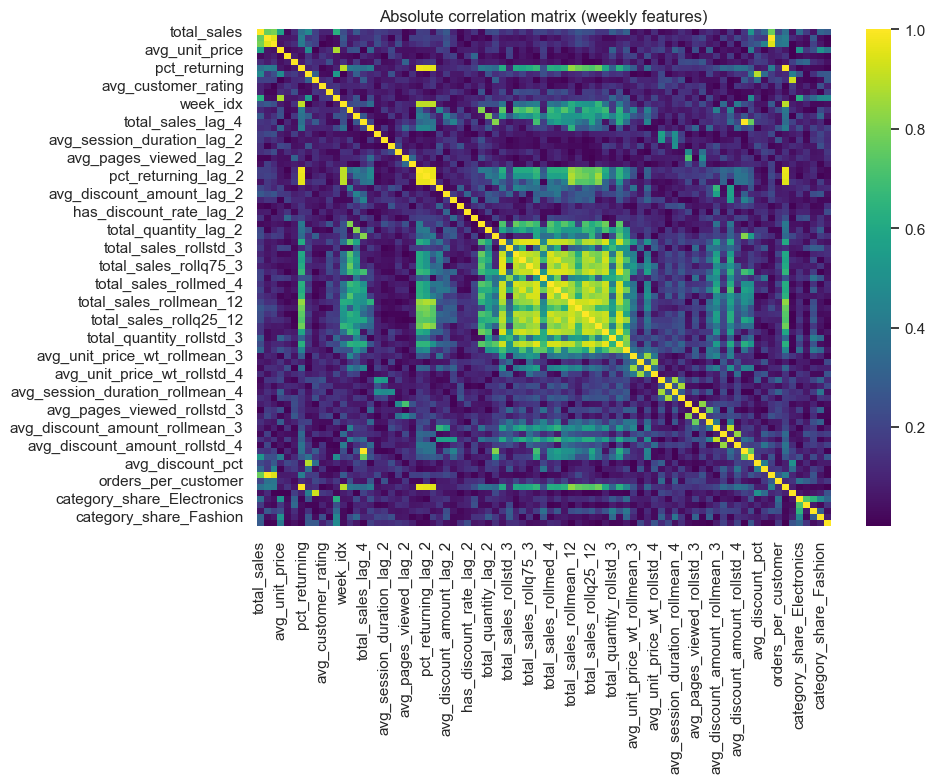

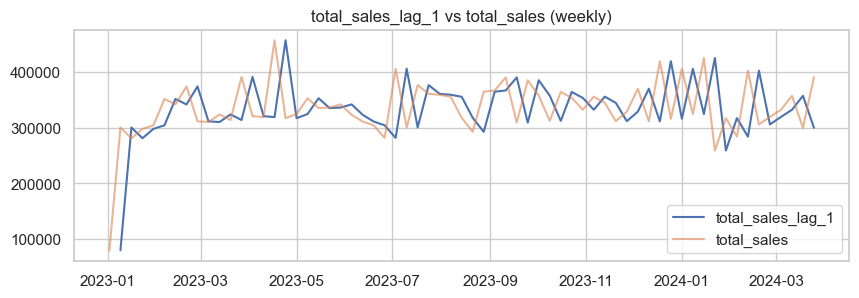

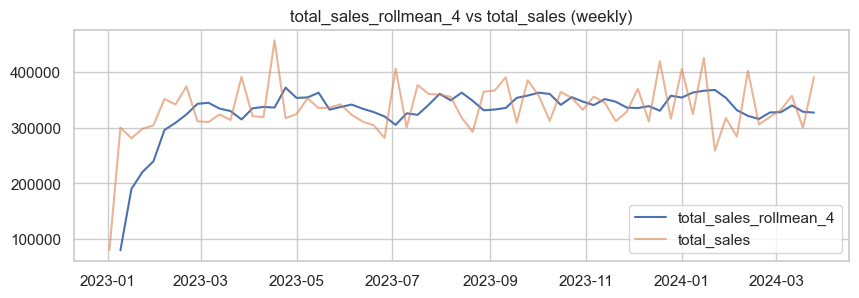

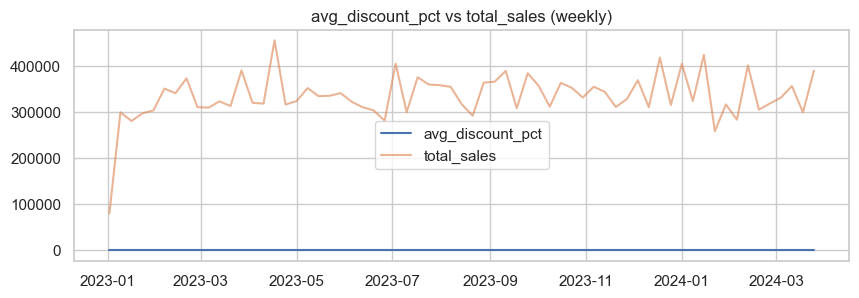

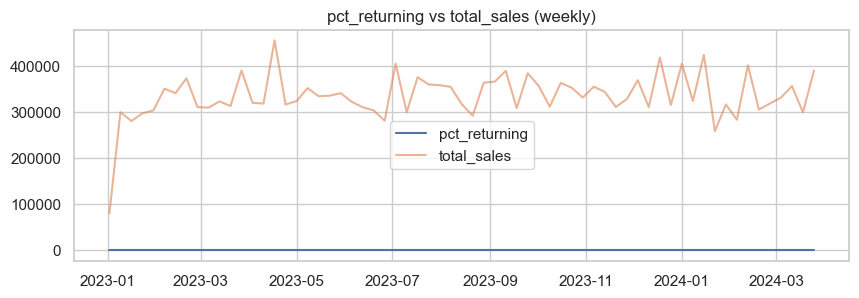

In [64]:
# Cell 17 — Quick diagnostics: correlation of features, feature importance preview
plt.figure(figsize=(10,8))
sns.heatmap(weekly.select_dtypes(include=[np.number]).corr().abs(), cmap='viridis', vmax=1.0)
plt.title("Absolute correlation matrix (weekly features)")
plt.tight_layout()
plt.show()

# Plot a few features vs target
for col in ['total_sales_lag_1','total_sales_rollmean_4','avg_discount_pct','pct_returning'] :
    if col in weekly.columns:
        plt.figure(figsize=(10,3))
        plt.plot(weekly[col], label=col)
        plt.plot(weekly['total_sales'], label='total_sales', alpha=0.6)
        plt.legend()
        plt.title(f"{col} vs total_sales (weekly)")
        plt.show()
